Prueba de jupyter notebook
Ejemplos de uso de networkx para futuras referencias

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import math
import time
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx
from networkx.algorithms import community

import mymod as mod
from mymod import mymodularity

import tabusearch
from tabusearch import tabu_modularity_optimization

import importlib
importlib.reload(mod)
importlib.reload(tabusearch)

<module 'tabusearch' from 'c:\\Users\\proal\\Documents\\UC3M\\2021-2022\\2\\TFG\\clustpy\\tabusearch.py'>

Obtenemos datos de los nodos y enlaces de los csv:

In [2]:
nodes_path = r'C:\Users\proal\Documents\UC3M\2021-2022\2\TFG\codigo\Nodes_t1.csv'
edges_path = r'C:\Users\proal\Documents\UC3M\2021-2022\2\TFG\codigo\Edges_t1.csv'
df_nodes = pd.read_csv(nodes_path, sep = ';',encoding='unicode_escape')
df_edges = pd.read_csv(edges_path, sep = ';',encoding='unicode_escape')

Creamos grafo de todos los alumnos:

In [3]:
'''Funciones necesarias para dibujar el grafo'''
def divide_by_gender(dict_node_gen):
    '''
    Input:
    Dictionary with the format: node: 'H'. For example:
    {125: 'H',111: 'M'}

    Returns:
    partition as in list made of two frozensets containing the male and female nodes.
    '''
    males = []
    females = []
    for node in dict_node_gen:
        if dict_node_gen[node] == 'H':
            males.append(node)
        elif dict_node_gen[node] == 'M':
            females.append(node)
        else:
            print('Ni H ni M')

    
    return [frozenset(males),frozenset(females)]

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)
    communities = set(partition.values())
    # print(between_community_edges)
    # hypergraph = nx.DiGraph()
    hypergraph = nx.MultiDiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]
    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.shell_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


In [5]:
MDG = nx.MultiDiGraph()
MDG.add_nodes_from(df_nodes['Nodes'])

tuples_from_to = []
for i in range(len(df_edges)):
    #tuples_from_to.append((df_edges['from'][i],df_edges['to'][i],{"weight":df_edges['weight'][i]}))
    tuples_from_to.append((df_edges['from'][i],df_edges['to'][i],df_edges['weight'][i]))

MDG.add_weighted_edges_from(tuples_from_to)
# Obtenemos los sexos del insti entero:
print(df_nodes['Sexo'])

dict_alumnos_sexos = {} # guardamos nodo : 'H' / nodo : 'M'
for i in range(len(list(df_nodes))):
    dict_alumnos_sexos[list(df_nodes)[i]] = list(df_nodes['Sexo'])[i]

print(dict_alumnos_sexos)
# Comunidades segun paridad  
pares = frozenset([nodo for nodo in MDG.nodes if nodo%2 == 0])
impares = frozenset([nodo for nodo in MDG.nodes if nodo%2 != 0])
c = [pares,impares]
    
optimized_communities = tabu_modularity_optimization(MDG,c[:])
gender_communities  = divide_by_gender(dict_alumnos_sexos)



0      H
1      H
2      H
3      H
4      M
      ..
404    H
405    M
406    M
407    M
408    H
Name: Sexo, Length: 409, dtype: object
{'Nodes': 'H', 'Curso': 'H', 'Grupo': 'H', 'Sexo': 'H'}
max_idle seleccionado 1


KeyboardInterrupt: 

Creamos grafos por aulas:

C:\Users\proal\AppData\Local\Temp/ipykernel_22520/358917560.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alumnos_en_aula = df_nodes[df_nodes["Curso"] == "%sº ESO" % j][df_nodes["Grupo"] == "%s" % aula]['Nodes']


valores con multiplo max idle: 0.2
max_idle seleccionado 3.4000000000000004
resultados de aula con 17 alumnos
Tiempo utilizado 11.549729824066162
Modulariad inicial 0.102863329477903
Modulariad final 0.23620787045754094
--------------------------------------------------------------
valores con multiplo max idle: 0.5
max_idle seleccionado 8.5
resultados de aula con 17 alumnos
Tiempo utilizado 26.496958017349243
Modulariad inicial 0.102863329477903
Modulariad final 0.23101648868924335
--------------------------------------------------------------
valores con multiplo max idle: 1
max_idle seleccionado 17
resultados de aula con 17 alumnos
Tiempo utilizado 19.150752305984497
Modulariad inicial 0.102863329477903
Modulariad final 0.2244644986595655
--------------------------------------------------------------
valores con multiplo max idle: 1.5
max_idle seleccionado 25.5
resultados de aula con 17 alumnos
Tiempo utilizado 33.387855052948
Modulariad inicial 0.102863329477903
Modulariad final 0.

Text(0, 0.5, 'Tiempo (s)')

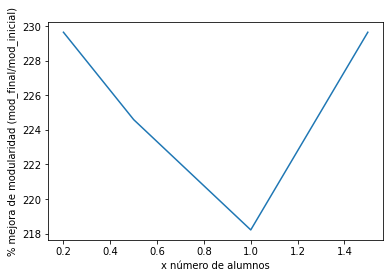

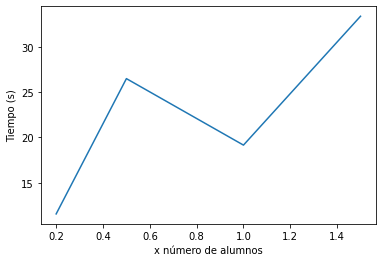

In [36]:
n_grados = df_nodes["Curso"].nunique()
grafos = []
results_dict = {}
for i in range(n_grados):
    j=i+1
    aulas = df_nodes[df_nodes["Curso"] == "%sº ESO" % j]['Grupo'].unique()
    n_aulas = df_nodes[df_nodes["Curso"] == "%sº ESO" % j]['Grupo'].nunique()

    for aula in aulas:
        newMDG = nx.MultiDiGraph()
        alumnos_en_aula = df_nodes[df_nodes["Curso"] == "%sº ESO" % j][df_nodes["Grupo"] == "%s" % aula]['Nodes']

        fromtos = []
        for alumno in alumnos_en_aula:
            fromtos.append(list(zip(list(df_edges.loc[df_edges['from'] == alumno]['from']),list(df_edges.loc[df_edges['from'] == alumno]['to']),list(df_edges.loc[df_edges['from'] == alumno]['weight']))))
        enlaces_aula = [item for sublist in fromtos for item in sublist]

        MDGaula = nx.MultiDiGraph()
        MDGaula.add_nodes_from(alumnos_en_aula)
        MDGaula.add_weighted_edges_from(enlaces_aula)
        grafos.append(MDGaula)
        results_dict["%sº ESO %s" % (j,aula)] = {'graph': MDGaula,'partition': None,'numero de alumnos': len(alumnos_en_aula) ,'init_modularity': None,'final_modularity': None}
#Hiperparametrizamos max_idle con múltiplos del tamaño de la red
max_idle_possibilities = [0.2,0.5,1,1.5]
tiempos = []
mejoras_modularidad = []
# print(list(results_dict).index('2º ESO B'))
string_clase = '1º ESO A'
for i in max_idle_possibilities:
    print('valores con multiplo max idle:',i)

    for clase in list(results_dict.keys())[list(results_dict).index(string_clase):list(results_dict).index(string_clase)+1]:# (hay 21 clases). Como esta escrito solo saca la clase string_clase
        
        MDG_clase = results_dict[clase]['graph']
        pares = frozenset([nodo for nodo in MDG_clase.nodes if nodo%2 == 0])
        impares = frozenset([nodo for nodo in MDG_clase.nodes if nodo%2 != 0])
        c = [pares,impares]

        results_dict[clase]['init_modularity'] = mymodularity(MDG_clase,c[:])

        start = time.time()
        optimized_communities = tabu_modularity_optimization(MDG_clase,c[:],max_idle = i*results_dict[clase]['numero de alumnos'])
        end = time.time()
        
        results_dict[clase]['final_modularity'] =  mymodularity(MDG_clase, optimized_communities[:])
        results_dict[clase]['partition'] = optimized_communities

    tiempos.append(end-start)
    
    mejoras_modularidad.append(results_dict[string_clase]['final_modularity']/results_dict[string_clase]['init_modularity'] * 100)

    print('resultados de aula con',results_dict[clase]['numero de alumnos'],'alumnos')
    print ("Tiempo utilizado", end - start)
    print('Modulariad inicial',results_dict[string_clase]['init_modularity'])
    print('Modulariad final',results_dict[string_clase]['final_modularity'])
    print('--------------------------------------------------------------')

plt.plot(max_idle_possibilities,mejoras_modularidad)
plt.xlabel('x número de alumnos')
plt.ylabel('% mejora de modularidad (mod_final/mod_inicial)')

plt.figure()
plt.plot(max_idle_possibilities,tiempos)
plt.xlabel('x número de alumnos')
plt.ylabel('Tiempo (s)')

Dibujamos grafo de distintas formas
Primero coloreando los enlaces positivos y negativos

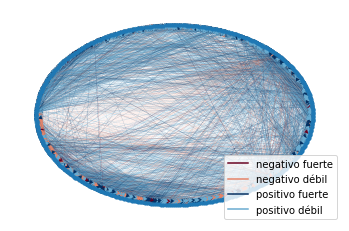

In [29]:
#Creamos leyenda en función de las relaciones
cNorm = colors.Normalize(vmin = df_edges['weight'].min(), vmax = df_edges['weight'].max())
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = plt.cm.RdBu)
ColorLegend = {'negativo fuerte': -2, 
           'negativo débil': -1, 
           'positivo fuerte': 2, 
           'positivo débil': 1}

f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)

plt.legend(loc = 'lower right')
nx.draw_shell(MDG,node_size=10,width = 0.1,vmin = df_edges['weight'].min(),vmax=df_edges['weight'].max(),edge_color=df_edges['weight'],edge_cmap=plt.cm.RdBu,ax=ax)
plt.show()

In [30]:
# nx.draw_random(MDG,node_size=10,width = 0.1,edge_color=df_edges['weight'],edge_cmap=plt.cm.RdBu)

# plt.show()

In [31]:
# nx.draw_spring(MDG,node_size=10,width = 0.1,edge_color=df_edges['weight'],edge_cmap=plt.cm.RdBu)
# print(MDG)
# plt.show()

[frozenset({208, 228, 277, 213, 200}), frozenset({257, 259, 263, 264, 268, 270, 275, 276, 282, 284, 285, 303, 311, 317, 319, 191, 193, 194, 195, 196, 197, 192, 199, 198, 201, 202, 203, 204, 205, 206, 207, 336, 209, 210, 212, 322, 215, 216, 217, 218, 220, 221, 350, 223, 224, 222, 227, 359, 234, 243, 244, 245, 247, 252, 254, 255}), frozenset({211})]
Partición con 3 comunidades


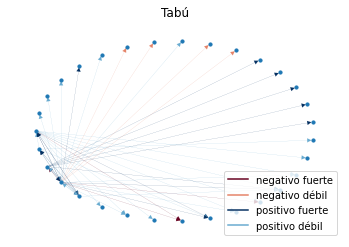

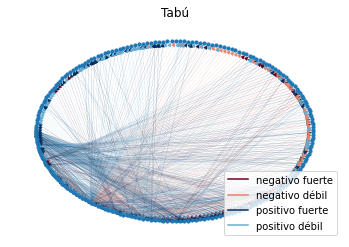

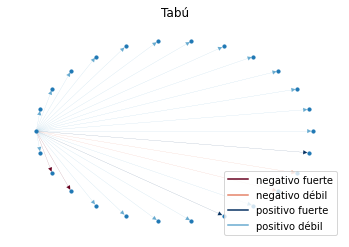

In [39]:
# c = list(community.modularity_max.greedy_modularity_communities(MDG1A))
for clase in list(results_dict.keys())[0:1]:
    c = results_dict[clase]['partition']
    print(c)
    print('Partición con',len(c),'comunidades')
    for k in c:
        mdg_iter = nx.MultiDiGraph()
        mdg_iter.add_nodes_from(k)
        tuples_from_to = []
        for i in k:
            # Encontramos filas de la lista de pesos que tenga de 'from' el nodo 'i' de esta comunidad
            rows_found = df_edges.loc[df_edges['from'] == i]
            list_from = rows_found['from'].tolist()
            list_to = rows_found['to'].tolist()
            list_weight = rows_found['weight'].tolist()

            for j in range(len(rows_found)):
                tuples_from_to.append((list_from[j], list_to[j], list_weight[j]))

        mdg_iter.add_weighted_edges_from(tuples_from_to)

        resulting_weights = list(map(lambda x: x[2], tuples_from_to))

        #Creamos leyenda en función de las relaciones
        cNorm = colors.Normalize(vmin = min(resulting_weights), vmax = max(resulting_weights))
        scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = plt.cm.RdBu)
        ColorLegend = {'negativo fuerte': -2, 
                'negativo débil': -1, 
                'positivo fuerte': 2, 
                'positivo débil': 1}

        f = plt.figure(1)
        ax = f.add_subplot(1,1,1)
        for label in ColorLegend:
            ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)
        plt.title('Tabú')
        plt.legend(loc = 'lower right')
        nx.draw_shell(mdg_iter,node_size=10,width = 0.1,vmin = min(resulting_weights), vmax = max(resulting_weights), edge_color = resulting_weights ,edge_cmap=plt.cm.RdBu,ax=ax)
        plt.show()